# Portfolio Risk Analysis

This notebook performs a risk analysis of your stock portfolio based on the data provided in `sample_holdings.csv`.

## 1. Setup

First, we import the necessary libraries. If you don't have them installed, you can install them using pip:

```
pip install pandas yfinance numpy matplotlib seaborn
```

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import time
from datetime import datetime, timedelta

sns.set_style('whitegrid')

## 2. Helper Functions

These functions help with cleaning and loading the data.

In [2]:
def clean_value(value):
    """Cleans and converts currency strings to float."""
    if isinstance(value, str):
        return float(value.replace('$', '').replace('+', '').replace(',', ''))
    return float(value)

def load_and_clean_positions(filepath):
    """
    Loads portfolio positions from a CSV, cleans the data,
    and aggregates positions by symbol.
    """
    positions = pd.read_csv(filepath)
    
    # Select relevant columns
    positions = positions[['Symbol', 'Description', 'Quantity', 'Current Value']]
    
    # Drop rows with no symbol
    positions.dropna(subset=['Symbol'], inplace=True)
    
    # Clean and convert 'Current Value' and 'Quantity'
    positions['Current Value'] = positions['Current Value'].apply(clean_value)
    positions['Quantity'] = pd.to_numeric(positions['Quantity'], errors='coerce')
    positions.dropna(subset=['Quantity'], inplace=True)

    # Aggregate positions by symbol
    aggregated_positions = positions.groupby('Symbol').agg({
        'Quantity': 'sum',
        'Current Value': 'sum',
        'Description': 'first'
    }).reset_index()
    
    return aggregated_positions

def calculate_beta(stock_returns, market_returns):
    """Calculates the beta of a stock relative to the market."""
    covariance = stock_returns.cov(market_returns)
    market_variance = market_returns.var()
    beta = covariance / market_variance
    return beta

## 3. Function for Loading Historical Data from CSV

This function loads historical data for a list of stock tickers from the `sample_history.csv` file.

In [3]:
def get_historical_data_from_csv(filepath):
    """Fetches historical stock data from a single CSV file."""
    all_close_prices = pd.DataFrame()
    
    print(f"Loading historical data from {filepath}...")
    try:
        all_close_prices = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        all_close_prices.index = all_close_prices.index.normalize()
        # Return empty list for failed_tickers as we handle it later
        return all_close_prices, [] 
    except Exception as e:
        print(f"Could not read data from {filepath}. Error: {e}")
        return pd.DataFrame(), []

## 4. Load, Clean, and Fetch Data

In [4]:
positions_df = load_and_clean_positions('sample_holdings.csv')
print("Loaded and aggregated portfolio holdings:")
print(positions_df.head())

close_prices, _ = get_historical_data_from_csv('sample_history.csv')

if not close_prices.empty:
    start_date = close_prices.index.min().strftime('%Y-%m-%d')
    end_date = close_prices.index.max().strftime('%Y-%m-%d')
else:
    start_date = "2020-01-01"
    end_date = "2025-01-01"

# Check for tickers in portfolio that are not in the historical data
tickers_in_portfolio = positions_df['Symbol'].unique().tolist()
tickers_in_history = close_prices.columns.tolist()
failed_tickers = list(set(tickers_in_portfolio) - set(tickers_in_history))

if failed_tickers:
    print(f"Could not retrieve data for the following tickers: {failed_tickers}")
    # Filter out tickers that we don't have history for from the positions dataframe
    positions_df = positions_df[~positions_df['Symbol'].isin(failed_tickers)]

# Filter historical data to only include tickers present in the portfolio
tickers_to_analyze = positions_df['Symbol'].unique().tolist()
close_prices = close_prices[tickers_to_analyze]

if close_prices.empty:
    print("Error: Could not retrieve any historical price data. Analysis cannot continue.")
else:
    print("Historical data processed successfully.")

Loaded and aggregated portfolio holdings:
  Symbol  Quantity  Current Value                Description
0   AAPL        50        13423.5                  Apple Inc
1    JPM       100        31421.0        JPMorgan Chase & Co
2   MSFT        50        24841.0             MICROSOFT CORP
3    SPY       100        67097.0     SPDR S&P 500 ETF Trust
4   UBER       100         9199.0  UBER TECHNOLOGIES INC COM
Loading historical data from sample_history.csv...
Historical data processed successfully.


## 5. Portfolio Composition

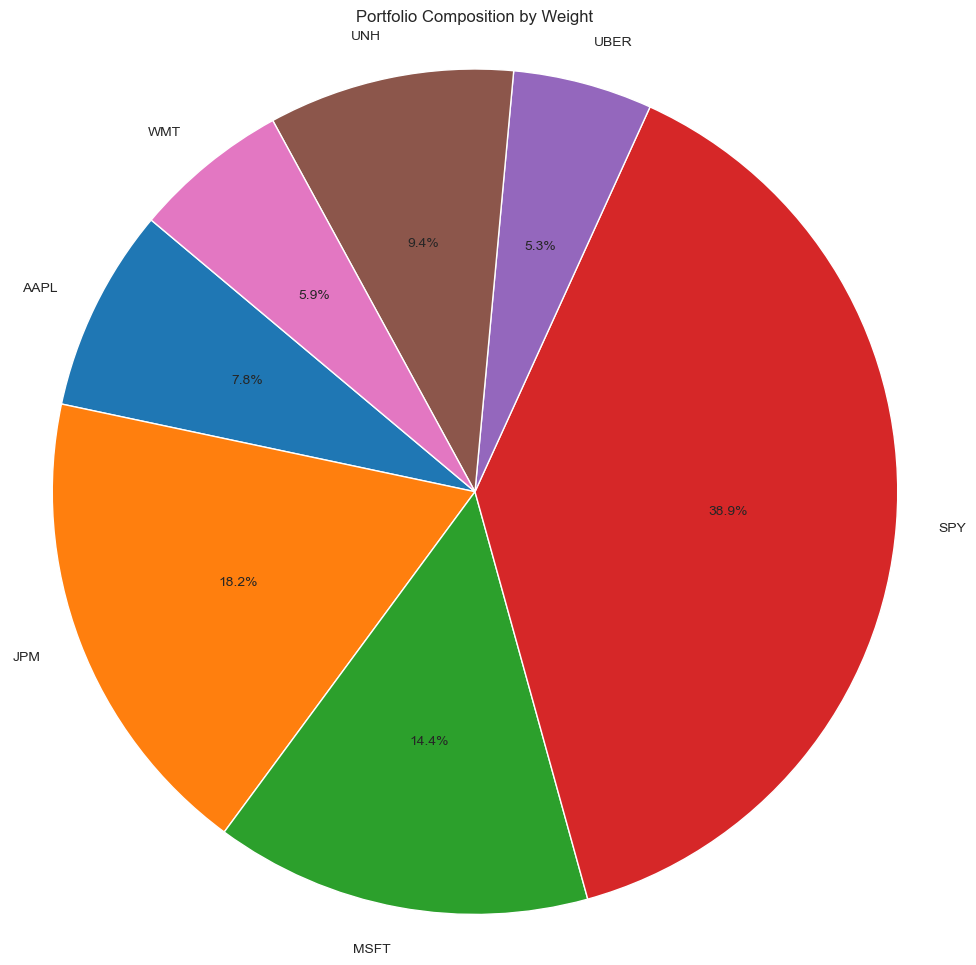

In [5]:
# Filter out any positions that failed to get price data
positions_df = positions_df[positions_df['Symbol'].isin(close_prices.columns)]

# Recalculate weights based on the valid, priced portfolio
total_portfolio_value = positions_df['Current Value'].sum()
if total_portfolio_value > 0:
    positions_df['Weight'] = positions_df['Current Value'] / total_portfolio_value
else:
    positions_df['Weight'] = 0

plt.figure(figsize=(12, 12))
plt.pie(positions_df['Weight'], labels=positions_df['Symbol'], autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Composition by Weight')
plt.axis('equal')
plt.show()

## 6. Risk Analysis

### 6.1 Daily Returns and Volatility

In [6]:
daily_returns = close_prices.pct_change().dropna(how='all')

# Individual Stock Volatility (Annualized)
annual_volatility = daily_returns.std() * np.sqrt(252)
print("Annualized Volatility of Individual Stocks:")
print(annual_volatility.sort_values(ascending=False))

Annualized Volatility of Individual Stocks:
UBER    0.525295
UNH     0.335993
AAPL    0.321269
JPM     0.316129
MSFT    0.297795
WMT     0.229896
SPY     0.209902
dtype: float64


### 6.2 Portfolio Returns and Volatility

In [7]:
weights = positions_df.set_index('Symbol')['Weight'].to_dict()
# Ensure weights are in the same order as daily_returns columns
aligned_weights = [weights.get(ticker, 0) for ticker in daily_returns.columns]

portfolio_returns = (daily_returns * aligned_weights).sum(axis=1)

# Portfolio Volatility (Annualized)
portfolio_volatility = portfolio_returns.std() * np.sqrt(252)
print(f"Annualized Portfolio Volatility: {portfolio_volatility:.2%}")

Annualized Portfolio Volatility: 21.83%


### 6.3 Correlation Matrix

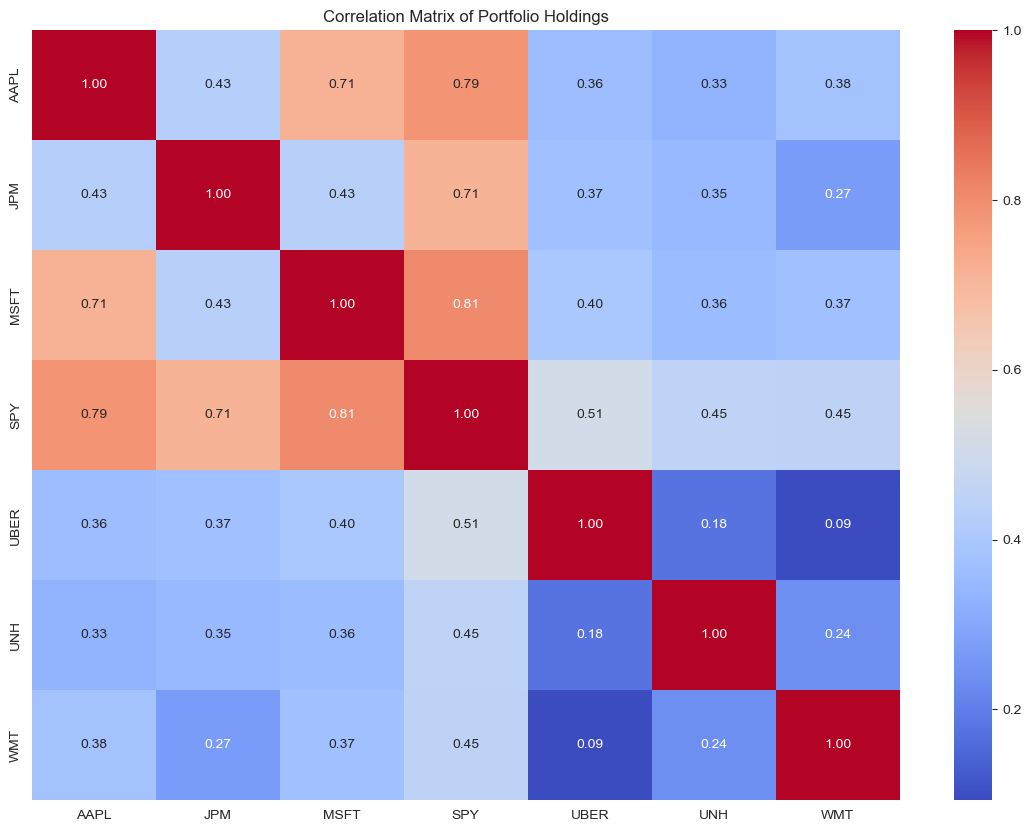

In [8]:
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Portfolio Holdings')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.4 Beta vs. S&P 500 (SPY)

In [9]:
market_ticker = 'SPY'

# Check if market ticker is in the portfolio, use it if so.
if market_ticker in daily_returns.columns:
    market_returns = daily_returns[market_ticker]
    # Don't calculate beta of the market against itself
    stock_returns_for_beta = daily_returns.drop(columns=[market_ticker])
else:
    # Fallback to downloading if CSV not found
    print(f"Market data for '{market_ticker}' not found in portfolio, attempting to download...")
    market_data = yf.download(market_ticker, start=start_date, end=end_date)['Close']
    market_returns = market_data.pct_change().dropna()
    stock_returns_for_beta = daily_returns

# Align data by joining
aligned_data = stock_returns_for_beta.join(market_returns.rename('market'), how='inner')

aligned_market_returns = aligned_data['market']
aligned_stock_returns = aligned_data.drop(columns=['market'])

betas = {}
for ticker in aligned_stock_returns.columns:
    betas[ticker] = calculate_beta(aligned_stock_returns[ticker], aligned_market_returns)

beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])
beta_df = beta_df.sort_values(by='Beta', ascending=False)

print("Stock Betas relative to S&P 500 (SPY):")
print(beta_df)

Stock Betas relative to S&P 500 (SPY):
          Beta
UBER  1.277602
AAPL  1.202929
MSFT  1.143252
JPM   1.070472
UNH   0.724999
WMT   0.491409


### 6.5 Value at Risk (VaR)

In [10]:
if not portfolio_returns.empty:
    confidence_level = 0.95
    var_95 = np.percentile(portfolio_returns, 100 * (1 - confidence_level))
    print(f"Daily Value at Risk (VaR) at {confidence_level:.0%} confidence level: {var_95:.2%}")

    var_amount = total_portfolio_value * var_95
    print(f"This means that on any given day, there is a 5% chance of losing {var_amount:,.2f} or more.")
else:
    print("Could not calculate Value at Risk because no portfolio returns were generated.")

Daily Value at Risk (VaR) at 95% confidence level: -1.91%
This means that on any given day, there is a 5% chance of losing -3,297.30 or more.
